This notebook is created by

Sridevi Pudipeddi, 
Camille Huynh, 
Eliza Thornton, 
Amaka Ozobia, 
Rebecca Roman, 
Tejaswini Reddy, 
Hindavi Churi

This project aims to Leverage NLP techniques to predict authentic disaster-related tweets to facilitate disaster relief organizations in taking quicker and effective actions by addressing the needs of affected communities.

# Importing libraries


In [1]:
#Importing all the neccessary libraries
import pandas as pd
import numpy as np #for linear algebra

#Libraries for visualisation
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

#Libraries for formattting and handling text 
import string
import re

#Library for nltk
import nltk 
import nltk.corpus
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
nltk.download('vader_lexicon')
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud



from collections import defaultdict
from collections import  Counter
stop=set(stopwords.words('english'))

#Library for NN
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from keras.initializers import Constant

# library for word2vec
import gensim

import sklearn
#Library for Splitting Dataset
from sklearn.model_selection import train_test_split
#Library for TFIDF
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, HashingVectorizer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn import model_selection, naive_bayes
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
#Library for evaluation
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,classification_report

import warnings
warnings.filterwarnings("ignore")

import plotly
plotly.offline.init_notebook_mode (connected = True)

!pip install neattext
import neattext as nt
from neattext.pipeline import TextPipeline
from neattext.functions import  remove_emails, fix_contractions, remove_numbers,remove_emojis,remove_special_characters, remove_stopwords, remove_html_tags, remove_urls, remove_puncts,remove_custom_pattern


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.7/114.7 KB 3.4 MB/s eta 0:00:00


##Reading the training data

In [2]:
# only considering train.csv
url = 'https://raw.githubusercontent.com/b3ccaMR/NLP-Disaster-Tweets/main/train.csv'
df = pd.read_csv(url)
df.head(5)
x = df["text"]
y = df["target"]
print(type(x))

<class 'pandas.core.series.Series'>


# Analyzing the data
Basic information about each column in the dataset like Non Null count and Data type.

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


Filling out null values for columns with missing count 

In [4]:
#filling in NA's for keyword and location
df['keyword'].fillna('no_keyword', inplace=True)
df['location'].fillna('no_location', inplace=True)

Text(0.5, 1.0, 'Total Counts of Real and Fake Disaster Tweets')

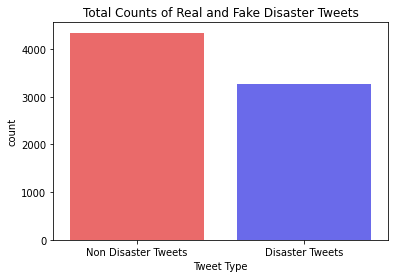

In [5]:
#graphing total counts of fake and real tweets
sns.countplot(x = df.target, data = df, palette = 'seismic_r')
labels = ["Non Disaster Tweets", "Disaster Tweets"]
plt.gca().set_xticklabels(labels)
plt.xlabel("Tweet Type")
plt.gca().set_title('Total Counts of Real and Fake Disaster Tweets')

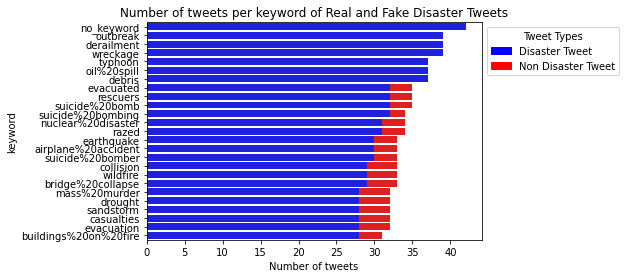

In [6]:
#Number of fake and real tweets according to keyword, TOP 25 only
keyword_fake = df[df['target'] == 0].groupby('keyword').count().drop(columns=['target', 'id']).sort_values(by='text', ascending=False)[:25]
keyword_real = df[df['target'] == 1].groupby('keyword').count().drop(columns=['target', 'id']).sort_values(by='text', ascending=False)[:25]

sns.barplot(data=keyword_fake,y=keyword_real.index, x = 'text',color='red',) #number of fake tweets
sns.barplot(data=keyword_real,y=keyword_real.index, x = 'text',color='blue')#number of real tweets
plt.gca().set_xlabel('Number of tweets')
plt.gca().set_title('Number of tweets per keyword of Real and Fake Disaster Tweets')
red = mpatches.Patch(color='red', label='Non Disaster Tweet')
blue = mpatches.Patch(color='blue', label='Disaster Tweet')
plt.legend(loc=2, title='Tweet Types',bbox_to_anchor = (1,1), handles = [blue, red])

From above ouptut we can see the count of keywords which often appear in tweets related to both disaster tweets and non-diasater tweets.

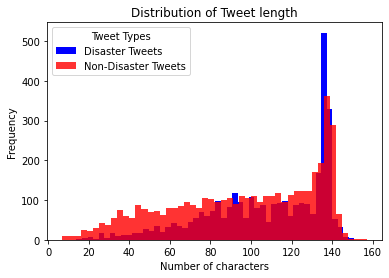

In [7]:
#Frequency distribution of tweets character lenght

real=df[df['target']==1]
fake = df[df['target']==0]

real_len = real['text'].str.len()
fake_len = fake['text'].str.len()

plt.hist(real_len, bins=50, alpha=1, label='Disaster Tweets', color='blue')
plt.hist(fake_len, bins=50, alpha=.8, label='Non-Disaster Tweets', color='red')

plt.xlabel('Number of characters')
plt.ylabel('Frequency')
plt.title('Distribution of Tweet length')
plt.legend(title = "Tweet Types")
plt.show()

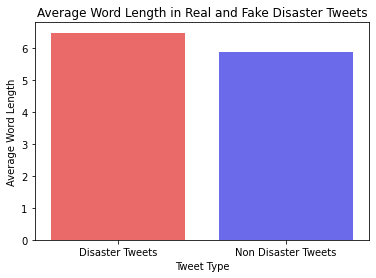

In [8]:
# Calculate the average word length for each set of tweets
real_avg_word_len = real["text"].str.split().apply(lambda x: sum(len(word) for word in x)/len(x)).mean()
fake_avg_word_len = fake["text"].str.split().apply(lambda x: sum(len(word) for word in x)/len(x)).mean()

sns.barplot(x = ["Disaster Tweets", "Non Disaster Tweets"],y = [real_avg_word_len,fake_avg_word_len], palette = 'seismic_r')
plt.title("Average Word Length in Real and Fake Disaster Tweets")
plt.xlabel("Tweet Type")
plt.ylabel("Average Word Length")
plt.show()

# Cleaning
---

Defining a function clean_data which takes the input text and processes it to remove unnecssary words/symbols, converting some words into appropriate words and overall processing to get clean text.

Finally, dividing training data into training and validation

In [ ]:

def clean_data(text):

    text = text.lower() # make it all lower case
    text = re.sub(r'\n', '', text) # take out any line breaks
    
    clean_pipeline = TextPipeline(steps=[remove_numbers, fix_contractions, 
                                            remove_stopwords, remove_emails,remove_emojis, 
                                            remove_html_tags, remove_urls, remove_special_characters])

    text = clean_pipeline.transform(text)
 
    lemmatizer = WordNetLemmatizer()
    text = " ".join([lemmatizer.lemmatize(word) for word in text.split()])

    return text


# apply the "clean" function to the data frame, and put the cleaned text in a new column
df['clean_text'] = df['text'].map(clean_data)
# Remove duplicate texts AFTER removing @'s, web addresses,  and non-word characthers
df = df.drop_duplicates(subset='text', keep="first")


# Sentiment analysis
---
Applying simple sentiment analysis to predict the polarity of given text

In [10]:
# Sentiment analysis real tweets
sentiment_real = pd.DataFrame()
sentiment_real['text'] = real['text'].apply(clean_data)

sia = SentimentIntensityAnalyzer()

sentiment_real['sentiment'] = sentiment_real['text'].apply(lambda x: sia.polarity_scores(x))
sentiment_real['max_type'] = sentiment_real['sentiment'].apply(lambda x: max(x, key=x.get))
sent_dict = {'neg': 'negative', 'pos': 'positive', 'neu': 'neutral'}
sentiment_real['max_type'] = sentiment_real['max_type'].replace(sent_dict)
sentiment_real['max_score'] = sentiment_real['sentiment'].apply(lambda x: x[max(x, key=x.get)])
sentiment_real.head()

,text,sentiment,max_type,max_score
0,deed reason earthquake allah forgive,"{'neg': 0.0, 'neu': 0.656, 'pos': 0.344, 'comp...",neutral,0.656
1,forest fire near la ronge sask canada,"{'neg': 0.286, 'neu': 0.714, 'pos': 0.0, 'comp...",neutral,0.714
2,resident asked shelter place notified officer ...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1.000
3,people receive wildfire evacuation order calif...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1.000
4,got sent photo ruby alaska smoke wildfire pour...,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1.000


In [11]:
# Sentiment analysis fake tweets
sentiment_fake = pd.DataFrame()
sentiment_fake['text'] = fake['text'].apply(clean_data)

sia = SentimentIntensityAnalyzer()

sentiment_fake['sentiment'] = sentiment_fake['text'].apply(lambda x: sia.polarity_scores(x))
sentiment_fake['max_type'] = sentiment_fake['sentiment'].apply(lambda x: max(x, key=x.get))

sentiment_fake['max_type'] = sentiment_fake['max_type'].replace(sent_dict)
sentiment_fake['max_score'] = sentiment_fake['sentiment'].apply(lambda x: x[max(x, key=x.get)])
sentiment_fake.head()

,text,sentiment,max_type,max_score
15,man,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1.000
16,love fruit,"{'neg': 0.0, 'neu': 0.192, 'pos': 0.808, 'comp...",positive,0.808
17,summer lovely,"{'neg': 0.0, 'neu': 0.208, 'pos': 0.792, 'comp...",positive,0.792
18,car fast,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1.000
19,goooooooaaaaaal,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",neutral,1.000


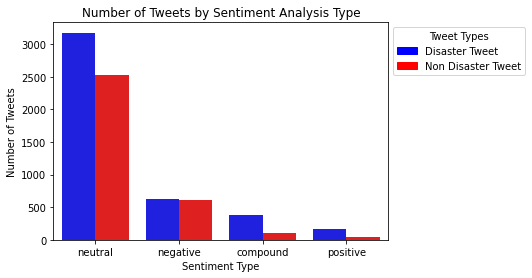

In [12]:
#Graph to display Number of Tweets by Sentiment Analysis Type
sentiment_counts = pd.DataFrame()
sentiment_counts['Real_Tweets'] = sentiment_real.groupby(['max_type']).size()
sentiment_counts['Fake_Tweets'] = sentiment_fake.groupby(['max_type']).size()

sentiment_counts = sentiment_counts.reset_index()
sentiment_counts = sentiment_counts.melt(id_vars=['max_type'], var_name='tweet_type', value_name='count').sort_values('count', ascending=False)

sns.barplot(x='max_type', y='count', hue='tweet_type', data=sentiment_counts, palette=["blue", "red"])
plt.xlabel('Sentiment Type')
plt.ylabel('Number of Tweets')
plt.title('Number of Tweets by Sentiment Analysis Type')
plt.legend(loc=2, title='Tweet Types',bbox_to_anchor = (1,1), handles = [blue, red])
plt.show()

# Vectorization
---
We define a vectorization method to map the phrases into a vector of real number defined by some criteria.

In this project, we'll be comparing 2 different different vectorization techniques:

1) Word2vec (to find relationships between words used to describe disasters)

2) TFIDF (using word frequencies to find which words are important in determining if a text is about disasters)



In [13]:
#split up the data into train / test
x_train, x_val, y_train, y_val = train_test_split(df['clean_text'], df['target'] , test_size=0.2)


# Vectorize using TDIF
tfidf_vect = TfidfVectorizer(max_features=5000)
tfidf_vect.fit(x_train)

x_train_tfidf = tfidf_vect.transform(x_train)
x_val_tfidf = tfidf_vect.transform(x_val)

# Train the word2vec model
sentences = [nltk.word_tokenize(sent) for sent in df['clean_text']]
w2v_model = gensim.models.Word2Vec(sentences,
                                   vector_size=100, 
                                   window=5,
                                   min_count=2)
words = set(w2v_model.wv.index_to_key)

#vectorize the X_train and X_test data with word2vec
x_train_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in x_train])
x_val_vect = np.array([np.array([w2v_model.wv[i] for i in ls if i in words])
                         for ls in x_val])

# Compute sentence vectors by averaging the word vectors for the words contained in the sentence
x_train_w2v = []
for v in x_train_vect:
    if v.size:
        x_train_w2v.append(v.mean(axis=0))
    else:
        x_train_w2v.append(np.zeros(100, dtype=float))
        
x_val_w2v = []
for v in x_val_vect:
    if v.size:
        x_val_w2v.append(v.mean(axis=0))
    else:
        x_val_w2v.append(np.zeros(100, dtype=float))


Defined a function with a list of machine learning models that are executed to check the accuracy score for validation data.

It will print the accuracy score for each model and will return the best model based on its accuracy.

In [14]:
def model_exec(x_train, y_train, x_val, y_val, models=None):
    if models is None:  #executed when the function is called first time
       models = [
              LogisticRegression(),
              DecisionTreeClassifier(),
              GradientBoostingClassifier(),
 #             GaussianNB(),
              KNeighborsClassifier(),
              RandomForestClassifier(),
              sklearn.svm.SVC(),
              sklearn.svm.SVC(C=10),
              sklearn.svm.SVC(C=0.5),
            ]
    else:
        if not isinstance(models, list):
            models = list(models)
            
    accuracy_models = []
    for model in models:
        model.fit(x_train, y_train.values.ravel())
        predictions = model.predict(x_val)
        print("Accuracy Score -> ", model , accuracy_score(predictions, y_val)*100) #prints accuracy score for each model
        accuracy_models.append((accuracy_score(predictions, y_val)*100))   #,model)
        
    print(accuracy_models)
    return accuracy_models   # returns the model accuracy score

Calling the model_exe function with our training and validation data and displaying the results

In [15]:
# set up a dataframe to compare our results
list_of_models = index = ['Logistic Regression','Decision Tree Classifier','Gradient Boosting Classifier',
                          #'Naive Bayes',
                          'KNN', 'Random Forest', 'SVC()','SVC(C=10)','SVC(C=0.5)']
results  = pd.DataFrame(index = list_of_models)
              
# first call the model using TFIDF vectorized data
print('Models analyzed with TFIDF vectorized data')
model_accuracy= model_exec(x_train_tfidf, y_train, 
                                      x_val_tfidf, y_val)

results['TFIDF accuracy']=model_accuracy

#now call the model using W2V vectorized data
print('Models analyzed with Word2Vec vectorized data')
model_accuracy = model_exec(x_train_w2v, y_train, 
                                      x_val_w2v, y_val)
results['Word2Vec accuracy']=model_accuracy


Models analyzed with TFIDF vectorized data
Accuracy Score ->  LogisticRegression() 80.54630246502332
Accuracy Score ->  DecisionTreeClassifier() 71.4856762158561
Accuracy Score ->  GradientBoostingClassifier() 73.08461025982677
Accuracy Score ->  KNeighborsClassifier() 66.4890073284477
Accuracy Score ->  RandomForestClassifier() 77.74816788807462
Accuracy Score ->  SVC() 80.41305796135909
Accuracy Score ->  SVC(C=10) 79.3471019320453
Accuracy Score ->  SVC(C=0.5) 78.08127914723516
[80.54630246502332, 71.4856762158561, 73.08461025982677, 66.4890073284477, 77.74816788807462, 80.41305796135909, 79.3471019320453, 78.08127914723516]
Models analyzed with Word2Vec vectorized data
Accuracy Score ->  LogisticRegression() 56.82878081279147
Accuracy Score ->  DecisionTreeClassifier() 59.7601598934044
Accuracy Score ->  GradientBoostingClassifier() 62.891405729513664
Accuracy Score ->  KNeighborsClassifier() 58.02798134576948
Accuracy Score ->  RandomForestClassifier() 64.55696202531645
Accuracy S

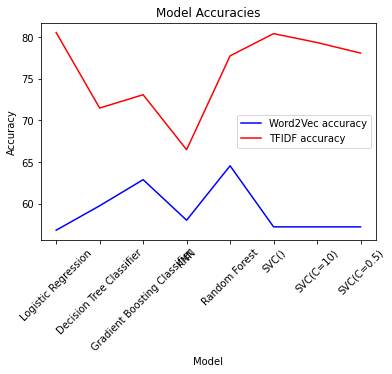

In [16]:
# Let's plot these out so we can compare them: 

fig, ax = plt.subplots()

# plot the w2v accuracy line
ax.plot(results.index, results['Word2Vec accuracy'], color='blue', label='Word2Vec accuracy')

# plot the tfidf accuracy line
ax.plot(results.index, results['TFIDF accuracy'], color='red', label='TFIDF accuracy')

# add axis labels and title
ax.set_xticklabels(results.index, rotation=45)
ax.set_xlabel('Model')
ax.set_ylabel('Accuracy')
ax.set_title('Model Accuracies')
ax.legend()

# display the plot
plt.show()

# Analysis
TFIDF vectorization beats Word2Vec in all instances for this dataset. 

The best model is SVM by default C value with accuracy score of 80.88%

In [17]:
best_model = sklearn.svm.SVC()
best_model.fit(x_train_tfidf, y_train)
y_predict_val = best_model.predict(x_val_tfidf)
as_svc = accuracy_score(y_predict_val,y_val)
print('The accuracy score of SVC is '+ str(as_svc))


The accuracy score of SVC is 0.8041305796135909


In [18]:
test_url = 'https://raw.githubusercontent.com/b3ccaMR/NLP-Disaster-Tweets/main/test.csv'
test_df = pd.read_csv(test_url)

In [19]:
# apply the "clean" function to the test data frame, and put the cleaned text in a new column
test_df['clean_text'] = test_df['text'].map(clean_data)
test_tfidf = tfidf_vect.transform(test_df['clean_text'])
test_predictions = best_model.predict(test_tfidf)


In [20]:
test_predictions

array([1, 1, 1, ..., 1, 1, 1])

In [22]:
submission = pd.DataFrame({'id': test_df['id'], 'target': test_predictions })
submission.to_csv('submission.csv', index=False)
submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [23]:
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
submission.to_csv('/content/drive/My Drive/submission.csv', index=False)